In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas_datareader.data as web

## Load the dataset - CAC40 from Yahoo

In [2]:
startDate = pd.to_datetime('2005-01-01')
endDate = pd.to_datetime('2020-11-15')
df = web.DataReader("^FCHI", data_source='yahoo', start = startDate,end = endDate)

In [3]:
df.tail()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2020-11-09,5387.490234,5021.330078,5036.919922,5336.319824,0.0,5336.319824
2020-11-10,5439.080078,5327.220215,5351.310059,5418.970215,0.0,5418.970215
2020-11-11,5462.950195,5408.669922,5433.660156,5445.209961,0.0,5445.209961
2020-11-12,5421.399902,5348.629883,5394.370117,5362.569824,0.0,5362.569824
2020-11-13,5411.120117,5343.250000,5343.319824,5380.160156,0.0,5380.160156


In [5]:
data = df["Close"]
last_15_days = data.tail(15)
print(last_15_days)

Date
2020-10-26    4816.120117
2020-10-27    4730.660156
2020-10-28    4571.120117
2020-10-29    4569.669922
2020-10-30    4594.240234
2020-11-02    4691.140137
2020-11-03    4805.609863
2020-11-04    4922.850098
2020-11-05    4983.990234
2020-11-06    4960.879883
2020-11-09    5336.319824
2020-11-10    5418.970215
2020-11-11    5445.209961
2020-11-12    5362.569824
2020-11-13    5380.160156
Name: Close, dtype: float64


In [6]:
print(data.head())

Date
2005-01-03    3855.679932
2005-01-04    3863.300049
2005-01-05    3829.360107
2005-01-06    3856.479980
2005-01-07    3877.959961
Name: Close, dtype: float64


In [7]:
data = data.reset_index()

In [8]:
print(len(data))

4056


In [9]:
separating_date = pd.to_datetime('2017-01-01')
training_data = data[data['Date'] < separating_date].copy()
test_data = data[data['Date'] >= separating_date].copy()

In [10]:
print("Training data : " + str(len(training_data)) + ", Testing data : " + str(len(test_data)))

Training data : 3067, Testing data : 989


In [11]:
training_data = training_data.set_index('Date')
test_data = test_data.set_index('Date')

Text(0.5, 1.0, 'CAC40 Close Price')

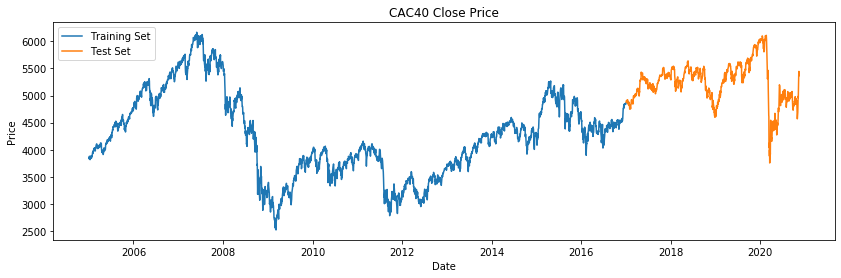

In [12]:
plt.figure(figsize=(14,4))
plt.plot(training_data['Close'])
plt.plot(test_data['Close'])
plt.ylabel("Price")
plt.xlabel("Date")
plt.legend(["Training Set", "Test Set"])
plt.title("CAC40 Close Price")

# Feature scaling

In [13]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
training_data_scaled = scaler.fit_transform(training_data)

# Creating data with timesteps

In [14]:
X_train=[]
y_train=[]

for i in range(60, len(training_data_scaled)):
    temp_data = training_data_scaled[i-60:i, 0]
    X_train.append(temp_data)
    #y_train.append(np.mean(temp_data))
    y_train.append(training_data_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)
print(X_train.shape, y_train.shape)

(3007, 60) (3007,)


In [15]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1],1))

In [16]:
print(X_train.shape, y_train.shape)

(3007, 60, 1) (3007,)


# Building the LSTM
To build the LSTM we need to import a few modules from keras:

    Sequential for initializing the neural network <br />
    Dense for adding a densely connected network layer <br />
    LSTM for adding the Long-Short-Term Memory layer <br />
    Dropout for adding dropout layers that prevent overfitting <br /><br />
After making the predictions we use inverse_transform to get back the stock prices in normal readable format

In [17]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras import optimizers

Using TensorFlow backend.
C:\Users\Hp\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Hp\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Hp\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\Hp\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:519: Future

In [18]:
regressor = Sequential()

In [19]:
regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.5))

regressor.add(Dense(units = 1))

In [20]:
optimizer = optimizers.Adam(clipvalue=0.5)
regressor.compile(optimizer = optimizer, loss = 'mean_squared_error')

In [21]:
regressor.fit(X_train, y_train,epochs = 20, batch_size = 200)


Epoch 1/20
3007/3007 [==============================] - 5s 2ms/step - loss: 0.0806
Epoch 2/20
3007/3007 [==============================] - 5s 2ms/step - loss: 0.0191
Epoch 3/20
3007/3007 [==============================] - 5s 2ms/step - loss: 0.0117
Epoch 4/20
3007/3007 [==============================] - 5s 2ms/step - loss: 0.0102
Epoch 5/20
3007/3007 [==============================] - 5s 2ms/step - loss: 0.0095
Epoch 6/20
3007/3007 [==============================] - 5s 2ms/step - loss: 0.0093
Epoch 7/20
3007/3007 [==============================] - 5s 2ms/step - loss: 0.0095
Epoch 8/20
3007/3007 [==============================] - 5s 2ms/step - loss: 0.0090
Epoch 9/20
3007/3007 [==============================] - 5s 2ms/step - loss: 0.0085
Epoch 10/20
3007/3007 [==============================] - 5s 2ms/step - loss: 0.0083
Epoch 11/20
3007/3007 [==============================] - 5s 2ms/step - loss: 0.0075
Epoch 12/20
3007/3007 [==============================] - 5s 2ms/step - loss: 0.0080


In [22]:
original_test_data = test_data.copy()
test_data_for_prediction = training_data[-60:].append(original_test_data)
test_data_scaled = scaler.fit_transform(test_data_for_prediction)
print(test_data_scaled.shape, test_data.shape)
X_test = []
y_test = []

for i in range(60, len(test_data_scaled)):
    X_test.append(test_data_scaled[i-60:i,0])
    y_test.append(test_data_scaled[i,0])
X_test, y_test = np.array(X_test), np.array(y_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1],1))

(1049, 1) (989, 1)


In [23]:
predicted_price = regressor.predict(X_test)
print(predicted_price.shape, y_test.shape)
y_test = np.reshape(y_test, (y_test.shape[0], 1))

(989, 1) (989,)


In [24]:
predicted_price = scaler.inverse_transform(predicted_price)
y_test = scaler.inverse_transform(y_test)
predicted_price = pd.DataFrame(predicted_price)
predicted_price.rename(columns = {0:'CAC40_predicted'}, inplace = True)
predicted_price = predicted_price.round(decimals=0)
predicted_price.index = test_data.index
print(max(y_test))
print(predicted_price['CAC40_predicted'].max(), predicted_price['CAC40_predicted'].min())

[6111.24023438]
5811.0 4188.0


# Plotting the results

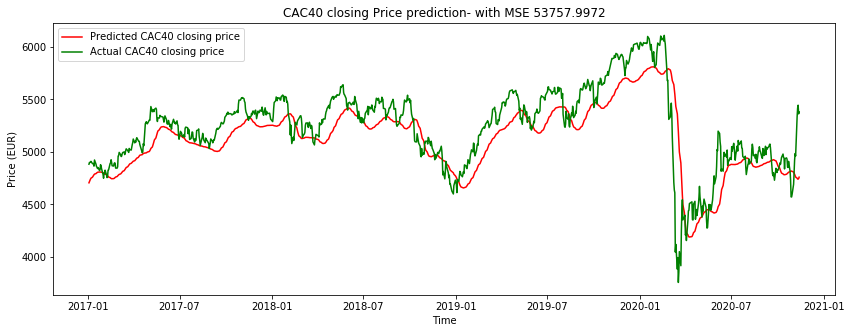

In [25]:
from sklearn.metrics import mean_squared_error
plt.figure(figsize = (14,5))
mse = mean_squared_error(y_test, predicted_price)
plt.plot(predicted_price['CAC40_predicted'], color = 'red', label = 'Predicted CAC40 closing price')
plt.plot(test_data['Close'], color = 'green', label = 'Actual CAC40 closing price')
plt.title("CAC40 closing Price prediction- with MSE {:10.4f}".format(mse))
plt.xlabel('Time')
plt.ylabel('Price (EUR)')
plt.legend()

### Forecasting future stock

In [26]:
n = test_data_scaled.shape[0]
X_forecast = test_data_scaled[n-60:n+1,0]
X_forecast = np.array(X_forecast)
preds = []
n_days_ahead = 5
for i in range(0,n_days_ahead):
    X_forecast = np.reshape(X_forecast, (1, X_forecast.shape[0], 1))
    y_pred_scaled = regressor.predict(X_forecast)
    y_pred = scaler.inverse_transform(y_pred_scaled)
    y_pred = np.reshape(y_pred, (np.shape(y_pred)[0]))
    print(y_pred)
    y_pred_scaled = np.reshape(y_pred_scaled, (np.shape(y_pred_scaled)[0]))
    preds.append(y_pred)
    X_forecast = np.reshape(X_forecast, (X_forecast.shape[1]))
    X_forecast = np.concatenate((X_forecast, y_pred_scaled), axis=0)
    X_forecast = X_forecast[-60:]
    n = X_forecast.shape[0]

[4779.9937]
[4806.257]
[4834.663]
[4862.345]
[4887.0713]


In [32]:
prediction = np.concatenate([predicted_price, preds], axis=0)
prediction.shape

(994, 1)

In [33]:
#plt.figure(figsize = (14,5))
#plt.title("MSE {:10.4f}".format(mse))
#mse = mean_squared_error(y_test, predicted_price)
#plt.plot(predicted_price["CAC40_predicted"], color = 'red', label = 'Predicted CAC40 closing price')
#plt.plot(prediction, color = 'blue', label = 'Forecast for the future')
#plt.plot(test_data["Close"], color = 'green', label = 'Actual CAC40 closing price')
#plt.title("CAC40 closing Price prediction- with MSE {:10.4f}".format(mse))
#plt.xlabel('Time')
#plt.ylabel('Price (EUR)')
#plt.legend()